# imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# project path
import os
project_path = '/content/drive/My Drive/DataScience/supercoop/supercoapp-data-analysis/'
os.chdir(project_path)

In [3]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
sns.set()

import src

# load data

In [6]:
def load_data(folder_path):
  # list all files in folder_path 
  listdir = os.listdir(folder_path)
  print(listdir)

  # read csv and create dataframes
  for csv in listdir:
    if 'orders' in csv:
      df_orders = pd.read_csv(folder_path + csv, 
                              index_col='order_ID',
                              parse_dates=['delivery_date','created_at','updated_at'])
    elif 'members' in csv:
      df_members = pd.read_csv(folder_path + csv, 
                              #index_col=['member_ID', 'order_ID']
                              )
    elif 'products' in csv:
      df_products = pd.read_csv(folder_path + csv, 
                                index_col=['order_ID', 'product_ID']
                                )
  return df_orders, df_members, df_products

In [7]:
# set folder path
folder_path = '/content/drive/My Drive/DataScience/supercoop/supercoapp-data-analysis/data/processed/'
# load data
df_orders, df_members, df_products = src.load_data(folder_path)

['20201217_scoop_members.csv', '20201217_scoop_products.csv', '20201217_scoop_orders.csv']


In [9]:
# check if dates have been parsed
df_orders.dtypes

supplier_ID                           int64
delivery_date                datetime64[ns]
created_at                   datetime64[ns]
updated_at                   datetime64[ns]
open_order                             bool
scoop_margin                        float64
supplier_margin                     float64
total_order_value                   float64
num_participating_members             int64
dtype: object

In [8]:
df_products.head(2)

name  ... net_total_price
order_ID product_ID                                                ...                
1        3                  Artischockenherzen geviertelt in Lake  ...           17.94
         4           Tomaten getrocknet in Olivenöl, extra saftig  ...           25.92

[2 rows x 13 columns]

# create new col fields

## df_products

In [ ]:
# create column 'net_total_price' (net_price * amount_ordered) for each product
df_products['net_total_price'] = df_products.net_price * df_products.amount_ordered

## df_orders

In [ ]:
# get total_order_value
total_order_value = df_products.groupby('order_ID')['net_total_price'].sum()
df_orders['total_order_value'] = total_order_value.round(2)

# get num_participating_members
df_orders['num_participating_members'] = df_members.groupby('order_ID').size()

## df_members

In [ ]:
# calculate order value for each member
from ast import literal_eval
import yaml

df_members['order_request_value'] = np.nan

# step 1: loop through df_members to get 'order_ID' and 'order_requests'
for i in df_members.index:
    order_ID = df_members.order_ID[i]
    yaml_test = yaml.load(df_members.order_requests[i])
    print(type(yaml_test))
    break
    order_request = literal_eval(df_members.order_requests[i]) # literal_eval() turns order_request to dict
    print(type(order_request))
    break
    # step 2: get 'product_ID' and quantity filled from order_request
    # dict into df
    order_request_df = pd.DataFrame(order_request, index=['filled', 'ordered']).T.reset_index() # setting index to prevent issues with missing dict keys 
    product_ID = order_request_df['index']
    filled_amount = order_request_df['filled'].replace(',', '.', regex=True) # replace instances woth ','
    filled_amount = filled_amount.replace(r'^\s*$', 0, regex=True).astype('float') # replace empty strings

    # step 3: access net_price from df_products and calculate order_request_value
    # -> df_products.loc[(order_ID, product_ID), 'net_price']
    net_price = df_products.loc[(order_ID, product_ID), 'net_price'].reset_index(drop=True)
    
    order_request_value = np.sum(net_price * filled_amount).round(2)
    
    # Step 4: assign order_request_value to df_members
    df_members.loc[i , 'order_request_value'] = order_request_value

<class 'dict'>


In [ ]:
## adding delivery_dates to members DF

# solution with merge
df_members = df_members.merge(df_orders['delivery_date'].reset_index(), 
                             how='left',
                             on='order_ID'
                             )

# explorativ analysis

## Orders

### orders over time

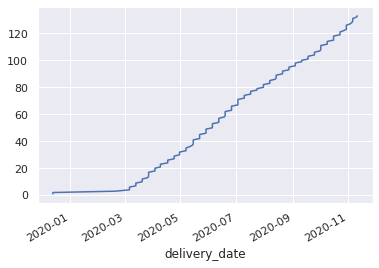

In [ ]:
# cumulativ orders over time
delivery_dates = pd.Series(df_orders['delivery_date']).sort_values().reset_index(drop=True)
orders_over_time = pd.Series(delivery_dates.index + 1, index=delivery_dates)
orders_over_time.plot()

# notes: 
# * ammount of orders changed 2020-07. what happend?
#   -   

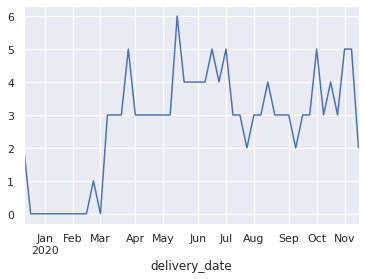

In [ ]:
# deliverys each week
orders_over_time.resample('W').count().plot()

### order value distribution

Text(0, 0.5, 'order count')

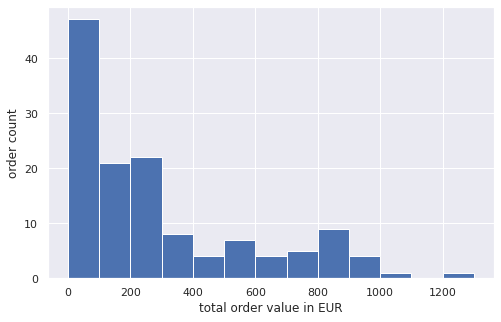

In [ ]:
# count of order by value bins
df_orders['total_order_value'].hist(bins=range(0, 1400, 100), 
                                    figsize=(8,5))
plt.xlabel('total order value in EUR')
plt.ylabel('order count')

# Anmerkungen:
# * Woher kommen die vielen kleinen Bestellungen? 
#   - evtl. Nachbestellungen, Korrekturen oder Nischenprodukte, Testen von neuen Lieferanten?
# * Wie ist der Aufwand/Mehrwert Nutzen von einer Bestellungen? 
#   - Wie aufwendig ist es Mitglieder kleiner Bestellungen aufzugeben bzw. anzunehmen?

### order value (turnover) each month

In [ ]:
# groupby total_order_value
df_orders.groupby([df_orders.delivery_date.dt.year, df_orders.delivery_date.dt.month])['total_order_value'].sum()

## Anmerkung
# vor allem der July war ein schlechter monat, warum?

delivery_date  delivery_date
2019           12                720.24
2020           2                 546.02
               3                4645.42
               4                5567.27
               5                5336.35
               6                4600.13
               7                2628.86
               8                4651.95
               9                2425.87
               10               5542.41
               11               2572.25
Name: total_order_value, dtype: float64

## Suppliers

In [ ]:
# unique supplier ids
unique_supplier_ids = df_orders.supplier_ID.unique()
print('unique_supplier_ids: ', unique_supplier_ids, 
      '\nnum_unique_supplier_ids: ', len(unique_supplier_ids))

unique_supplier_ids:  [ 1  2  3  4  8 10  9 11 12 14 13 15] 
num_unique_supplier_ids:  12


In [ ]:
# orders from suppliers count
df_orders.groupby('supplier_ID')['delivery_date'].count()

supplier_ID
1      8
2      1
3     36
4     27
8     36
9      1
10     2
11     8
12     2
13     3
14     6
15     3
Name: delivery_date, dtype: int64

In [ ]:
df_orders.head()

,supplier_ID,delivery_date,created_at,updated_at,open_order,scoop_margin,supplier_margin,total_order_value,num_participating_members
order_ID,,,,,,,,,
1,1,2019-12-13,2019-12-09 21:16:00.457949,2020-02-18 20:25:54.887435,False,0.033,NaN,692.36,19
2,2,2019-12-13,2019-12-10 19:41:12.570392,2020-02-18 20:26:03.234562,False,0.033,NaN,27.88,12
3,1,2020-02-20,2020-02-18 19:47:52.410238,2020-02-29 16:00:54.012728,False,0.033,NaN,546.02,23
4,3,2020-03-06,2020-03-03 21:49:25.220836,2020-03-14 16:55:16.884711,False,0.033,NaN,179.16,22
5,4,2020-03-06,2020-03-03 21:53:42.646177,2020-03-14 16:55:25.637982,False,0.033,10.0,502.54,24


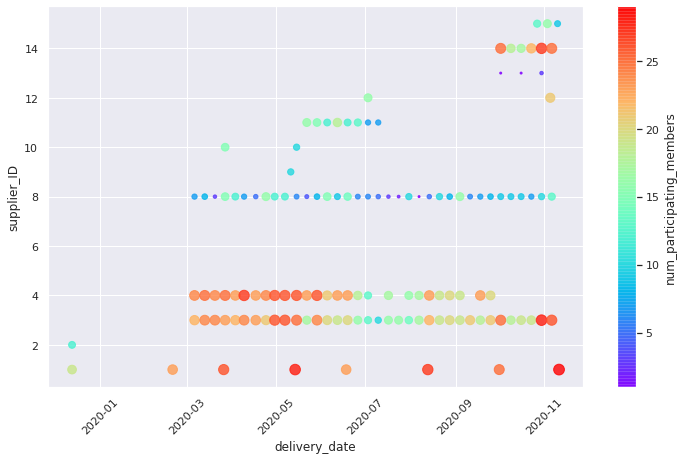

In [ ]:
# popularity of suppliers by delivery date: 
df_orders.plot.scatter(x='delivery_date', 
                       y='supplier_ID',
                       c='num_participating_members',
                       cmap='rainbow',
                       s=df_orders['num_participating_members']*4, # size
                       alpha=0.8, # transparent
                       sharex=False, # fix for missing xlabels bug
                       xlabel='time', 
                       rot=45, # rotation
                       figsize=(12,7))

### beliebtheit von suppliern

In [ ]:
#df_orders.loc[(slice(None), 1),['num_participating_members'].mean()
#df_orders

In [ ]:

# avg num_participating_members for each supplier
df_orders.groupby('supplier_ID')['num_participating_members'].mean()
# avg order_value of members for each supplier
df_suppliers = df_orders.groupby('supplier_ID')[['num_participating_members', 'total_order_value']].mean()
df_suppliers['avg_order_value_per_member'] = df_suppliers['total_order_value'] / df_suppliers['num_participating_members'] 
df_suppliers['num_orders'] = df_orders.groupby('supplier_ID')['num_participating_members'].count()

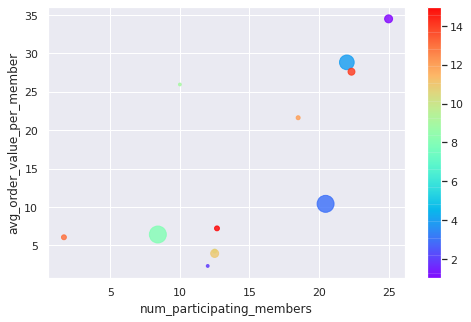

In [ ]:
df_suppliers.plot.scatter(x='num_participating_members', 
                     y='avg_order_value_per_member', 
                     c=df_suppliers.index, 
                     cmap='rainbow',
                     figsize=(8,5),
                     s=df_suppliers['num_orders']*8, # Size
                     sharex=False,
                     alpha=0.8)

In [ ]:
df_suppliers

,num_participating_members,total_order_value,avg_order_value_per_member,num_orders
supplier_ID,,,,
1,25.000000,862.450000,34.498000,8
2,12.000000,27.880000,2.323333,1
3,20.472222,213.100000,10.409227,36
4,22.000000,634.344444,28.833838,27
8,8.416667,54.011667,6.417228,36
9,10.000000,259.530000,25.953000,1
10,12.500000,53.280000,4.262400,2
11,12.500000,49.375000,3.950000,8
12,18.500000,400.030000,21.623243,2


## produktvielfalt

In [ ]:
df_members

,member_ID,order_ID,name,collected?,order_requests,deposits,order_request_value,delivery_date,order_cumcount
0,1,1,XXX,True,"{'3': {'filled': '1.0', 'ordered': '1.0'}, '25...",NaN,89.49,2019-12-13,1
1,2,1,XXX,True,"{'39': {'filled': '1.0', 'ordered': '1.0'}, '6...",NaN,16.22,2019-12-13,1
2,3,1,XXX,True,"{'3': {'filled': '0.0', 'ordered': '2.0'}, '7'...",NaN,20.28,2019-12-13,1
3,4,1,XXX,True,"{'27': {'filled': '1.0', 'ordered': '1.0'}, '4...",NaN,11.96,2019-12-13,1
4,7,1,XXX,True,"{'27': {'filled': '1.0', 'ordered': '1.0'}, '1...",NaN,17.32,2019-12-13,1
...,...,...,...,...,...,...,...,...,...
2190,58,194,XXX,True,"{'212': {'filled': '2.0', 'ordered': '2.0'}, '...",NaN,7.76,2020-11-11,9
2191,60,194,XXX,True,"{'268': {'filled': '1.0', 'ordered': '1.0'}}",NaN,1.63,2020-11-11,9
2192,61,194,XXX,True,"{'25': {'filled': '3.0', 'ordered': '3.0'}, '7...",NaN,15.66,2020-11-11,4
2193,62,194,XXX,True,"{'25': {'filled': '1.0', 'ordered': '1.0'}, '2...",NaN,15.54,2020-11-11,5


## Members
defenition of an active member: 
- member orders at least once a week / 40 times a year
- member used the service in the last 4 weeks

### members order count

In [ ]:
# calculating number of orders for each member
n_orders = df_members.groupby('member_ID')['name'].count()
# calculating the pct of members ordering more than 10 times
pct_more_than_10 = np.sum(n_orders >= 10) / n_orders.count()

print(f'{100 * pct_more_than_10:.2f}% of members ordered more than ten times.')

74.47% of members ordered more than ten times.


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


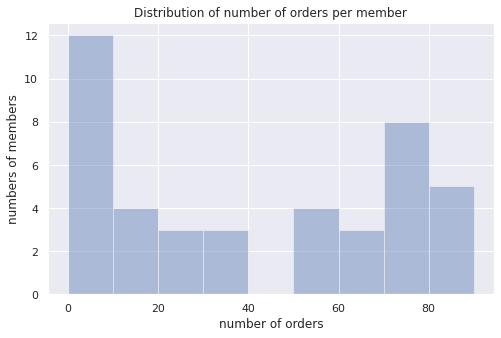

In [ ]:
# plot of the distribution of the number of orders per member
plt.figure(figsize=(8,5))
ax = sns.distplot(n_orders, 
                  kde=False, 
                  hist=True,
                  bins=range(0,100,10))
ax.set(title='Distribution of number of orders per member',
       xlabel='number of orders', 
       ylabel='numbers of members'
       );

### member activity
- first seen
- monthly cohort
-------------------
ideas:
1. members cumcount timeseries graph for order count, order values
2. scatter plots order freq / order value

calc min max avg

In [ ]:
# calculate min, max and count
members_activity = df_members.groupby('member_ID')['delivery_date'].agg(['min', 'max', 'count'])
# calculate the customer life span
members_activity['life_span'] = members_activity['max'] - members_activity['min']

# calculate the 'avg_days_between_orders' in days
members_activity['avg_days_between_orders'] = members_activity['life_span'].dt.days / members_activity['count']

# calculate 'days_since_last_activity' in days
today = pd.Timestamp.today()
members_activity['days_scince_last_order'] = today - members_activity['max']
members_activity['days_scince_last_order'] = members_activity['days_scince_last_order'].dt.days

members_activity.head(20)

,min,max,count,life_span,avg_days_between_orders,days_scince_last_order
member_ID,,,,,,
1,2019-12-13,2020-11-11,106,334 days,3.150943,22
2,2019-12-13,2020-10-30,84,322 days,3.833333,34
3,2019-12-13,2020-11-11,87,334 days,3.839080,22
4,2019-12-13,2019-12-13,2,0 days,0.000000,356
6,2020-03-06,2020-11-11,96,250 days,2.604167,22
7,2019-12-13,2020-09-25,78,287 days,3.679487,69
9,2019-12-13,2020-11-11,77,334 days,4.337662,22
10,2020-02-20,2020-11-11,59,265 days,4.491525,22
11,2020-03-06,2020-11-11,57,250 days,4.385965,22


Text(0, 0.5, 'user count')

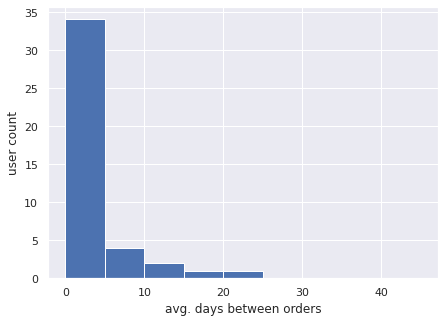

In [ ]:
# everage days between orders by members  
members_activity['avg_days_between_orders'].where(members_activity['avg_days_between_orders'] > 0).hist(figsize=(7,5),
                                                                                                        bins=range(0,50,5))
plt.xlabel('avg. days between orders')
plt.ylabel('user count')

## cumcount timeseries graph

In [ ]:
# creating new column 'order_cumcount'
df_members['order_cumcount'] = df_members.groupby('member_ID')['order_ID'].cumcount() + 1


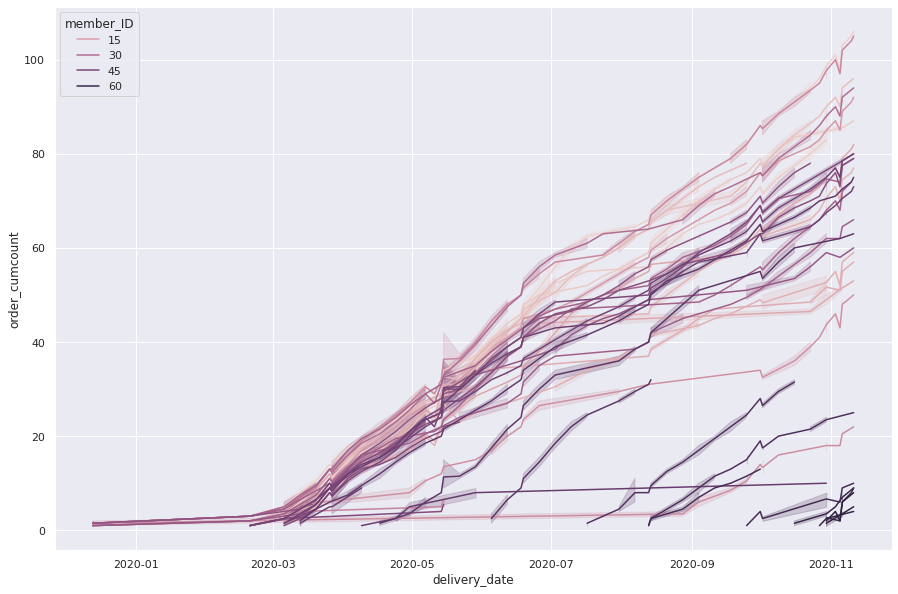

In [ ]:
# plot with seaborn
plt.figure(figsize=(15, 10))
sns.lineplot(data=df_members,
             x='delivery_date',
             y='order_cumcount',
             hue='member_ID')

### users - active_unique_users

In [ ]:
# when users last received an delivery
last_delivery = members_activity.groupby('max')['max'].count()

In [ ]:
# when users first received an delivery
first_delivery = members_activity.groupby('min')['min'].count()
first_delivery

min
2019-12-13    20
2020-02-20     8
2020-03-06     5
2020-03-13     2
2020-04-09     1
2020-04-17     1
2020-06-05     1
2020-07-17     1
2020-08-13     2
2020-09-25     1
2020-10-16     1
2020-10-27     1
2020-10-30     3
Name: min, dtype: int64

In [ ]:
user_timeline = pd.DataFrame(data=[first_delivery, last_delivery]).T
user_timeline.fillna(0, inplace=True)
user_timeline['active_unique_users'] = (user_timeline['min'] - user_timeline['max']).cumsum()
user_timeline

,min,max,active_unique_users
2019-12-13,20.0,4.0,16.0
2020-02-20,8.0,1.0,23.0
2020-03-06,5.0,0.0,28.0
2020-03-13,2.0,0.0,30.0
2020-04-09,1.0,1.0,30.0
2020-04-17,1.0,0.0,31.0
2020-05-15,0.0,2.0,29.0
2020-05-22,0.0,1.0,28.0
2020-05-29,0.0,1.0,27.0
2020-06-05,1.0,0.0,28.0


Text(0.5, 0, 'customer life span')

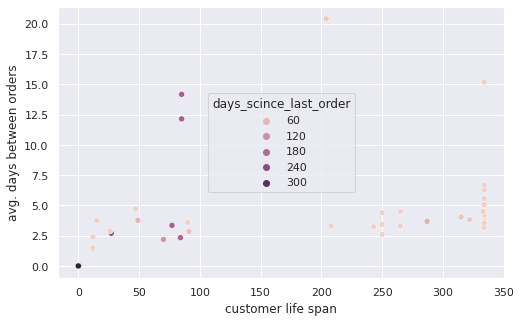

In [ ]:
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(x=members_activity['life_span'].dt.days.astype('int'), 
                y=members_activity['avg_days_between_orders'], 
                hue=members_activity.days_scince_last_order,
                #style=members_activity['min'].dt.quarter,
                )

plt.ylabel('avg. days between orders')
plt.xlabel('customer life span')


### member activity - scatterplot

In [ ]:
df_members

,member_ID,order_ID,name,collected?,order_requests,deposits,order_request_value,delivery_date,order_cumcount
0,1,1,XXX,True,"{'3': {'filled': '1.0', 'ordered': '1.0'}, '25...",NaN,89.49,2019-12-13,1
1,2,1,XXX,True,"{'39': {'filled': '1.0', 'ordered': '1.0'}, '6...",NaN,16.22,2019-12-13,1
2,3,1,XXX,True,"{'3': {'filled': '0.0', 'ordered': '2.0'}, '7'...",NaN,20.28,2019-12-13,1
3,4,1,XXX,True,"{'27': {'filled': '1.0', 'ordered': '1.0'}, '4...",NaN,11.96,2019-12-13,1
4,7,1,XXX,True,"{'27': {'filled': '1.0', 'ordered': '1.0'}, '1...",NaN,17.32,2019-12-13,1
...,...,...,...,...,...,...,...,...,...
2190,58,194,XXX,True,"{'212': {'filled': '2.0', 'ordered': '2.0'}, '...",NaN,7.76,2020-11-11,9
2191,60,194,XXX,True,"{'268': {'filled': '1.0', 'ordered': '1.0'}}",NaN,1.63,2020-11-11,9
2192,61,194,XXX,True,"{'25': {'filled': '3.0', 'ordered': '3.0'}, '7...",NaN,15.66,2020-11-11,4
2193,62,194,XXX,True,"{'25': {'filled': '1.0', 'ordered': '1.0'}, '2...",NaN,15.54,2020-11-11,5


In [ ]:
# a matrix that shows whom participated in which order at which date
df_members_activity = df_members.groupby(['delivery_date', 'order_ID', 'member_ID'])['order_requests'].count().unstack().T
#df_members_activity.fillna(0, inplace=T)
df_members_activity

delivery_date 2019-12-13      2020-02-20  ... 2020-11-06 2020-11-10 2020-11-11
order_ID             1    2          3    ...        192        193        194
member_ID                                 ...                                 
1                    1.0  1.0        1.0  ...        1.0        1.0        1.0
2                    1.0  NaN        1.0  ...        NaN        NaN        NaN
3                    1.0  NaN        1.0  ...        NaN        NaN        1.0
4                    1.0  1.0        NaN  ...        NaN        NaN        NaN
6                    NaN  NaN        NaN  ...        1.0        NaN        1.0
7                    1.0  NaN        1.0  ...        NaN        NaN        NaN
9                    1.0  1.0        1.0  ...        NaN        1.0        1.0
10                   NaN  NaN        1.0  ...        1.0        NaN        1.0
11                   NaN  NaN        NaN  ...        1.0        NaN        1.0
12                   1.0  1.0        1.0  ...        NaN        NaN        1.0
13                   NaN  NaN        1.0  ...        1.0        1.0        1.0
17                   1.0  NaN        1.0  ...        1.0        1.0        1.0
19                   NaN  1.0        1.0  ...        1.0        NaN        1.0
20                   1.0  1.0        NaN  ...        NaN        NaN        1.0
21                   1.0  NaN        NaN  ...        NaN        NaN        NaN
22                   1.0  1.0        1.0  ...        1.0        1.0        1.0
23                   NaN  NaN        1.0  ...        NaN        NaN        NaN
30                   1.0  1.0        1.0  ...        1.0        NaN        1.0
31                   1.0  NaN        NaN  ...        NaN        NaN        NaN
33                   1.0  1.0        1.0  ...        NaN        NaN        1.0
34                   1.0  NaN        1.0  ...        1.0        1.0        NaN
35                   1.0  1.0        1.0  ...        NaN        NaN        1.0
36                   NaN  NaN        1.0  ...        NaN        NaN        NaN
38                   1.0  NaN        1.0  ...        NaN        NaN        1.0
39                   1.0  1.0        1.0  ...        NaN        NaN        NaN
40                   1.0  1.0        NaN  ...        NaN        NaN        NaN
41                   NaN  NaN        1.0  ...        NaN        NaN        1.0
42                   NaN  NaN        NaN  ...        NaN        NaN        NaN
43                   NaN  NaN        1.0  ...        NaN        NaN        NaN
44                   NaN  NaN        1.0  ...        NaN        NaN        1.0
45                   NaN  NaN        NaN  ...        NaN        NaN        NaN
46                   NaN  NaN        1.0  ...        NaN        NaN        1.0
47                   NaN  NaN        NaN  ...        NaN        1.0        1.0
48                   NaN  NaN        NaN  ...        NaN        NaN        NaN
49                   NaN  NaN        NaN  ...        NaN        NaN        NaN
50                   NaN  NaN        NaN  ...        NaN        1.0        1.0
51                   NaN  NaN        NaN  ...        NaN        NaN        1.0
52                   NaN  NaN        NaN  ...        NaN        NaN        NaN
54                   NaN  NaN        NaN  ...        NaN        NaN        NaN
55                   NaN  NaN        NaN  ...        NaN        NaN        1.0
56                   NaN  NaN        NaN  ...        NaN        NaN        NaN
57                   NaN  NaN        NaN  ...        NaN        NaN        1.0
58                   NaN  NaN        NaN  ...        1.0        1.0        1.0
60                   NaN  NaN        NaN  ...        1.0        NaN        1.0
61                   NaN  NaN        NaN  ...        NaN        NaN        1.0
62                   NaN  NaN        NaN  ...        NaN        NaN        1.0
63                   NaN  NaN        NaN  ...        1.0        NaN        1.0

[47 rows x 133 columns]

In [ ]:
df_members_activity.sum(axis=0)

delivery_date  order_ID
2019-12-13     1           19.0
               2           12.0
2020-02-20     3           23.0
2020-03-06     4           22.0
               5           24.0
                           ... 
2020-11-06     190         26.0
               191         25.0
               192         13.0
2020-11-10     193          9.0
2020-11-11     194         29.0
Length: 133, dtype: float64

# Churn Prediction (logReg)
https://towardsdatascience.com/hands-on-predict-customer-churn-5c2a42806266

Questions:
- Which users users have a higher likelyhood to churn?
- Which features have the most impact on a customer leaving?

In [ ]:
df_members.head(2)

,index,member_ID,order_ID,name,collected?,order_requests,deposits,order_request_value,delivery_date,order_cumcount,delivery_date_month,cohort
0,0,1,1,XXX,True,"{'3': {'filled': '1.0', 'ordered': '1.0'}, '25...",NaN,89.49,2019-12-13,1,2019-12,2019-12
1,1,2,1,XXX,True,"{'39': {'filled': '1.0', 'ordered': '1.0'}, '6...",NaN,16.22,2019-12-13,1,2019-12,2019-12


## Feature selection (DataFrame members by ID)

In [ ]:
# create new DataFrame
members_by_ID = pd.DataFrame(df_members.groupby('member_ID').agg(
    cohort=('cohort', 'min'), # adds cohort tag
    first_ordered=('delivery_date', 'min'),
    last_ordered=('delivery_date', 'max'),
    lifetime_order_value=('order_request_value', 'sum'), # add lifetime_order_value
    lifetime_order_count=('order_ID', 'count') # add lifetime order count 
    ))

In [ ]:
# drop supercoop account with member_ID 46
members_by_ID.drop(46, inplace=True)

In [ ]:
# lifetime of a member
members_by_ID['lifetime_in_days'] = members_by_ID.last_ordered - members_by_ID.first_ordered
# lifetime in months
members_by_ID['lifetime_in_months'] = ((members_by_ID.last_ordered - members_by_ID.first_ordered) / np.timedelta64(1, 'M'))
# avg order count by month
members_by_ID['avg_order_count_mth'] = members_by_ID['lifetime_order_count'].divide(
    members_by_ID['lifetime_in_months']).replace(np.inf, 0)
# avg order value by month
members_by_ID['avg_order_value_mth'] = members_by_ID['lifetime_order_value'].divide(
    members_by_ID['lifetime_in_months']).replace(np.inf, 0)                                                                                                                   
# churned - not ordered in over 90 days
members_by_ID['churned_90d'] = (today - members_by_ID.last_ordered) > pd.Timedelta('90 days')

In [ ]:
# statistics of churned members 
members_by_ID[members_by_ID.churned_90d == True]

,cohort,first_ordered,last_ordered,lifetime_order_value,lifetime_order_count,lifetime_in_days,lifetime_in_months,avg_order_count_mth,avg_order_value_mth,churned_90d,max_days_between_orders
member_ID,,,,,,,,,,,
4,2019-12,2019-12-13,2019-12-13,15.36,2,0 days,0.000000,0.000000,0.000000,True,NaN
21,2019-12,2019-12-13,2019-12-13,3.63,1,0 days,0.000000,0.000000,0.000000,True,NaN
23,2020-02,2020-02-20,2020-05-15,29.73,7,85 days,2.792665,2.506566,10.645745,True,62.0
31,2019-12,2019-12-13,2019-12-13,186.85,1,0 days,0.000000,0.000000,0.000000,True,NaN
36,2020-02,2020-02-20,2020-02-20,66.64,1,0 days,0.000000,0.000000,0.000000,True,0.0
40,2019-12,2019-12-13,2019-12-13,24.68,2,0 days,0.000000,0.000000,0.000000,True,NaN
42,2020-03,2020-03-06,2020-05-22,162.08,23,77 days,2.529826,9.091534,64.067645,True,8.0
43,2020-02,2020-02-20,2020-05-15,37.95,6,85 days,2.792665,2.148485,13.589169,True,69.0
45,2020-03,2020-03-06,2020-05-29,755.52,36,84 days,2.759810,13.044375,273.757950,True,11.0


**What was the longest gap between orders of members?**
- between the first and second order was a 69d long gap, where no orders where placed. 
- bcause of this i started counting the period afterwards'

In [ ]:
# select columns 
longest_period = df_members.loc[:, ['member_ID', 'order_ID', 'delivery_date']]


longest_period = longest_period[longest_period.delivery_date >= pd.Timestamp('2020-02-20')]
longest_period['days_scince_last_order'] = longest_period.groupby(['member_ID'])['delivery_date'].diff()
longest_period['days_scince_last_order'] = pd.to_timedelta(longest_period['days_scince_last_order'], unit='D') # set datetime64[D]

In [ ]:
# add max_days_between_orders to members_by_ID DF
members_by_ID['max_days_between_orders'] = longest_period.groupby('member_ID')['days_scince_last_order'].max().astype('timedelta64[D]')
members_by_ID['max_days_between_orders'].fillna(0)

member_ID
1      21.0
2      27.0
3      21.0
4       0.0
6      28.0
7      21.0
9      55.0
10     34.0
11     90.0
12    119.0
13     28.0
17     15.0
19     50.0
20     21.0
21      0.0
22     21.0
23     62.0
30     20.0
31      0.0
33     15.0
34     56.0
35     35.0
36      0.0
38     43.0
39     22.0
40      0.0
41     22.0
42      8.0
43     69.0
44     41.0
45     11.0
47     22.0
48     14.0
49    154.0
50     15.0
51     28.0
52      7.0
54     14.0
55     14.0
56     14.0
57     29.0
58      7.0
60     14.0
61     12.0
62      7.0
63      6.0
Name: max_days_between_orders, dtype: float64

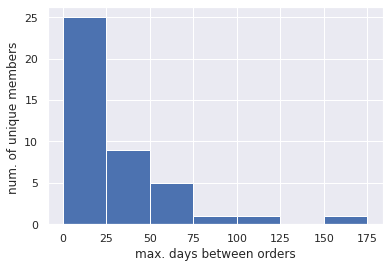

In [ ]:
# before plotting timedelta data -> .astype('timedelta64[D]')
# https://www.datasciencebytes.com/bytes/2015/05/16/pandas-timedelta-histograms-unit-conversion-and-overflow-danger/
members_by_ID['max_days_between_orders'].hist(bins=range(0, 200, 25))
plt.xlabel('max. days between orders')
plt.ylabel('num. of unique members ');

### scatter plots

In [ ]:
members_by_ID.head()

,cohort,first_ordered,last_ordered,lifetime_order_value,lifetime_order_count,lifetime_in_days,lifetime_in_months,avg_order_count_mth,avg_order_value_mth,churned_90d
member_ID,,,,,,,,,,
1,2019-12,2019-12-13,2020-11-11,3274.82,106,334 days,10.973531,9.659607,298.429003,False
2,2019-12,2019-12-13,2020-10-30,795.18,84,322 days,10.579273,7.940054,75.163957,False
3,2019-12,2019-12-13,2020-11-11,2138.84,87,334 days,10.973531,7.928168,194.908999,False
4,2019-12,2019-12-13,2019-12-13,15.36,2,0 days,0.000000,0.000000,0.000000,True
6,2020-03,2020-03-06,2020-11-11,2228.06,96,250 days,8.213721,11.687760,271.260735,False


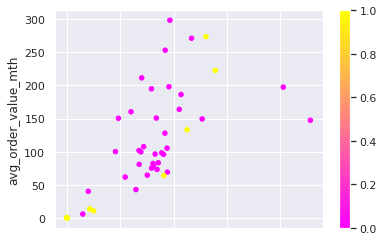

In [ ]:
# encode
churned_encoded = members_by_ID.churned_90d.map({True: 1, False: 0})
# avg order month vs. avg order count by month
members_by_ID.plot.scatter(x='avg_order_count_mth',
                           y='avg_order_value_mth',
                           c=churned_encoded,
                           cmap='spring'
                           )

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


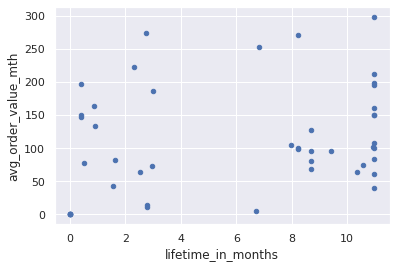

In [ ]:
members_by_ID.plot.scatter(x='lifetime_in_months',
                           y='avg_order_value_mth',
                           #c='cohort' # months since last order
                           )

### Logistic Regression model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

model = LogisticRegression()


## RFM churn prediction
* https://www.retentionscience.com/blog/rfm-king/

In [ ]:
# 

# Customer Segmentation
https://www.mktr.ai/applications-and-methods-in-data-science-customer-segmentation/

https://data-flair.training/blogs/r-data-science-project-customer-segmentation/